In [1]:
import sys
sys.path.append('../.')

from utils import *
from Data.DataGenerator import *
from Models.Models_normal import *
from Training.Spike_loss import *
import torch.optim as optim
from Training.Analysis import fixed_model_batch_analysis
from Data.DataLoader import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from sklearn.cluster import DBSCAN, SpectralClustering, AgglomerativeClustering, BisectingKMeans
from sklearn.linear_model import RANSACRegressor
from tqdm import tqdm
import numpy as np
import itertools
from sklearn.linear_model import RANSACRegressor

import torch

In [2]:
# Load the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10], bias=0)
# model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 32, 16, 8, 3], bias=0)
# model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10], bias=0)
data_path = '/home/mila/m/mehrab.hamidi/scratch/hidden_sym/all_results/sept_result_mnist/mnist_training/try_num0/epoch_60'

state_dict = torch.load(f'{data_path}/model.pth', weights_only=False)

model.load_state_dict(state_dict)

model.eval()


# load the data
_, _, _, train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = get_mnist_data_loaders()

Train Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Validation Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Test Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Train Samples Shape: torch.Size([50000, 784])
Train Labels Shape: torch.Size([50000])

Validation Samples Shape: torch.Size([10000, 784])
Validation Labels Shape: torch.Size([10000])

Test Samples Shape: torch.Size([10000, 784])
Test Labels Shape: torch.Size([10000])

Train Label Frequencies: Counter({1: 5678, 7: 5175, 3: 5101, 9: 4988, 2: 4968, 6: 4951, 0: 4932, 4: 4859, 8: 4842, 5: 4506})
Validation Label Frequencies: Counter({7: 1090, 1: 1064, 3: 1030, 8: 1009, 0: 991, 2: 990, 4: 983, 6: 967, 9: 961, 5: 915})
Test Label Frequencies: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


In [3]:
anal_path = '../../spike_analysis/spike_new_test/'
if not os.path.isdir(anal_path):
    os.makedirs(anal_path)
results_dict = fixed_model_batch_analysis(model, train_samples, train_labels, device, '{}_{}'.format(anal_path, 'train_'), 'analyze', plotting=False)
plt.close()
print("---")

---


In [20]:
def spike_detection_2d_lines(points, max_lines=30, min_points_for_line=100, residual_threshold=0.5, merge_threshold=0.01):
    merge_threshold = merge_threshold * (points.shape[1] - 1)
    residual_threshold *= (points.shape[1] - 1)

    def fit_line_ransac(points):
        # Randomly select two dimensions for fitting the line
        n_dims = points.shape[1]
        dim_indices = np.random.choice(n_dims, 2, replace=False)

        X = points[:, dim_indices[0]].reshape(-1, 1)  # Use one dimension as X
        y = points[:, dim_indices[1]]  # Use the other dimension as Y

        # Fit a line using RANSAC
        ransac = RANSACRegressor(LinearRegression(), 
                                 max_trials=1000, 
                                 min_samples=2,
                                 residual_threshold=residual_threshold,
                                 stop_probability=0.99)
        ransac.fit(X, y)
        return ransac, dim_indices

    def get_line_eq(ransac, dim_indices, n_dims):
        coef = ransac.estimator_.coef_[0]
        intercept = ransac.estimator_.intercept_

        # Set up the equation for the line in the n-dimensional space
        full_coef = np.zeros(n_dims)
        full_coef[dim_indices[0]] = coef
        full_coef[dim_indices[1]] = -1

        return full_coef, intercept

    def point_to_line_distance(point, coef, intercept):
        return np.abs(np.dot(coef, point) + intercept) / np.linalg.norm(coef)

    n_dims = points.shape[1]
    lines = []
    remaining_points = points.copy()
    assigned_points = []
    total_error = 0

    for _ in range(max_lines):
        if len(remaining_points) < min_points_for_line:
            break

        try:
            ransac, dim_indices = fit_line_ransac(remaining_points)
        except:
            return [], 0, []

        coef, intercept = get_line_eq(ransac, dim_indices, n_dims)
        
        inlier_mask = ransac.inlier_mask_
        inlier_points = remaining_points[inlier_mask]
        
        line_error = sum(point_to_line_distance(p, coef, intercept) for p in inlier_points)
        total_error += line_error
        
        lines.append((coef, intercept, len(inlier_points), line_error))
        assigned_points.append(inlier_points)
        
        remaining_points = remaining_points[~inlier_mask]
    
    if len(lines) == 0:
        return [], 0, []

    # Assign remaining points to the nearest line
    for point in remaining_points:
        distances = [point_to_line_distance(point, coef, intercept) for coef, intercept, _, _ in lines]
        nearest_line_index = np.argmin(distances)
        total_error += distances[nearest_line_index]
        assigned_points[nearest_line_index] = np.vstack([assigned_points[nearest_line_index], point])

    # Merge close lines
    i = 0
    while i < len(lines):
        j = i + 1
        while j < len(lines):
            angle, dist = _hyperplane_distance(lines[i][0], lines[i][1], lines[j][0], lines[j][1])
            if angle < merge_threshold:
                # Merge lines
                new_coef = (lines[i][0] + lines[j][0]) / 2
                new_intercept = (lines[i][1] + lines[j][1]) / 2
                new_inliers = lines[i][2] + lines[j][2]
                new_error = lines[i][3] + lines[j][3]
                new_points = np.vstack([assigned_points[i], assigned_points[j]])

                lines[i] = (new_coef, new_intercept, new_inliers, new_error)
                assigned_points[i] = new_points

                # Remove the merged line
                del lines[j]
                del assigned_points[j]
            else:
                j += 1
        i += 1

    # Sort lines by number of inliers (descending)
    lines = sorted(zip(lines, assigned_points), key=lambda x: x[0][2], reverse=True)
    lines, assigned_points = zip(*lines)

    return lines, total_error, assigned_points

Total error: 958.6833
Hyperplane 1:
Equation: -0.3160x1 + -1.4400x2 + 0.4522 = 0
Number of inliers: 2000
Hyperplane error: 400.9773
Hyperplane 2:
Equation: -0.6009x1 + -2.9698x2 + -0.5285 = 0
Number of inliers: 985
Hyperplane error: 197.8082
Hyperplane 3:
Equation: -0.1623x1 + -1.0000x2 + -0.4243 = 0
Number of inliers: 966
Hyperplane error: 181.0685
Hyperplane 4:
Equation: -0.9528x1 + -3.8989x2 + -2.3613 = 0
Number of inliers: 886
Hyperplane error: 115.3112


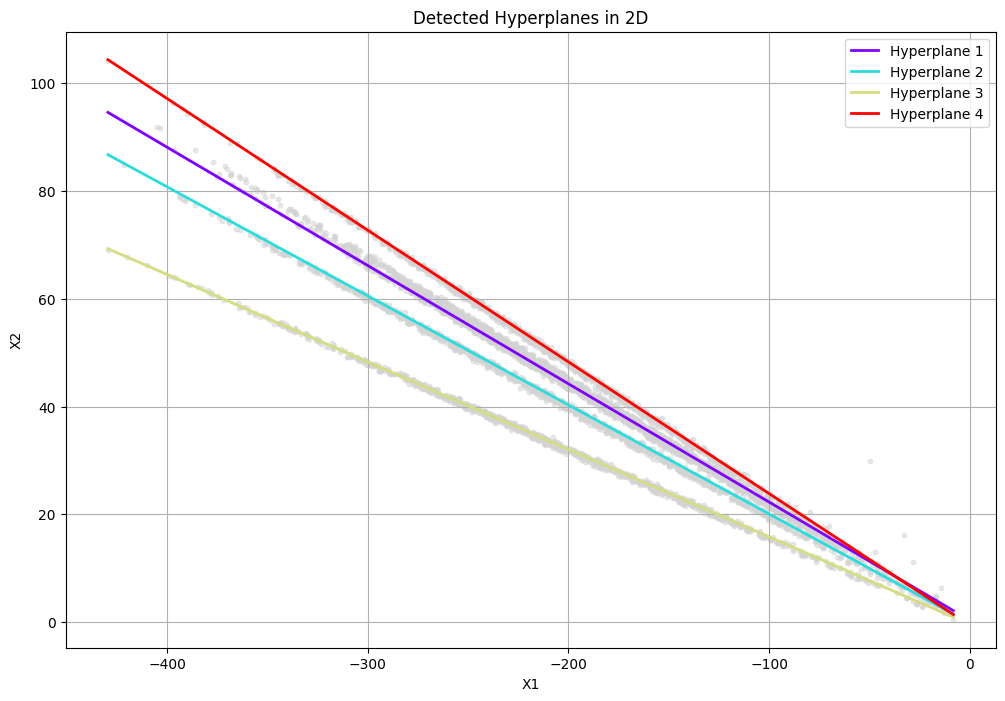

958.683324972887


In [21]:
# data = results_dict['representations'][11]

data = np.array(results_dict['pca_2'][10]).transpose()
data = torch.Tensor(data)

mnist_labels = train_labels.detach().cpu().numpy()
mnist_data = train_samples.detach().cpu().numpy().reshape(train_samples.shape[0], 28 * 28)

class_data_indices = np.where(mnist_labels == 0)[0]
class_data = data[class_data_indices]

points = class_data.clone()
# Detect hyperplanes
detected_hyperplanes, total_error, assigned_points = spike_detection_2d_lines(points.detach().cpu().numpy())

# Print results
print(f"Total error: {total_error:.4f}")
for i, (coef, intercept, num_inliers, hyperplane_error) in enumerate(detected_hyperplanes):
    print(f"Hyperplane {i+1}:")
    print(f"Equation: {' + '.join([f'{c:.4f}x{j+1}' for j, c in enumerate(coef)])} + {intercept:.4f} = 0")
    print(f"Number of inliers: {num_inliers}")
    print(f"Hyperplane error: {hyperplane_error:.4f}")


plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, len(detected_hyperplanes)))

# Plot all points
plt.scatter(points[:, 0], points[:, 1], c='lightgray', s=10, alpha=0.5)

# Plot assigned points and hyperplanes
for (coef, intercept, _, _), assigned, color in zip(detected_hyperplanes, assigned_points, colors):
    # plt.scatter(assigned[:, 0], assigned[:, 1], c=[color], s=20, alpha=0.7)
    
    # Plot hyperplane (line in 2D)
    x_range = np.array([points[:, 0].min(), points[:, 0].max()])
    y_range = (-coef[0] * x_range - intercept) / coef[1]
    plt.plot(x_range, y_range, c=color, linewidth=2, label=f'Hyperplane {len(plt.gca().lines) + 1}')

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Detected Hyperplanes in 2D')
plt.legend()
plt.grid(True)
plt.show()

print(total_error)

NameError: name 'plot_line_3d' is not defined

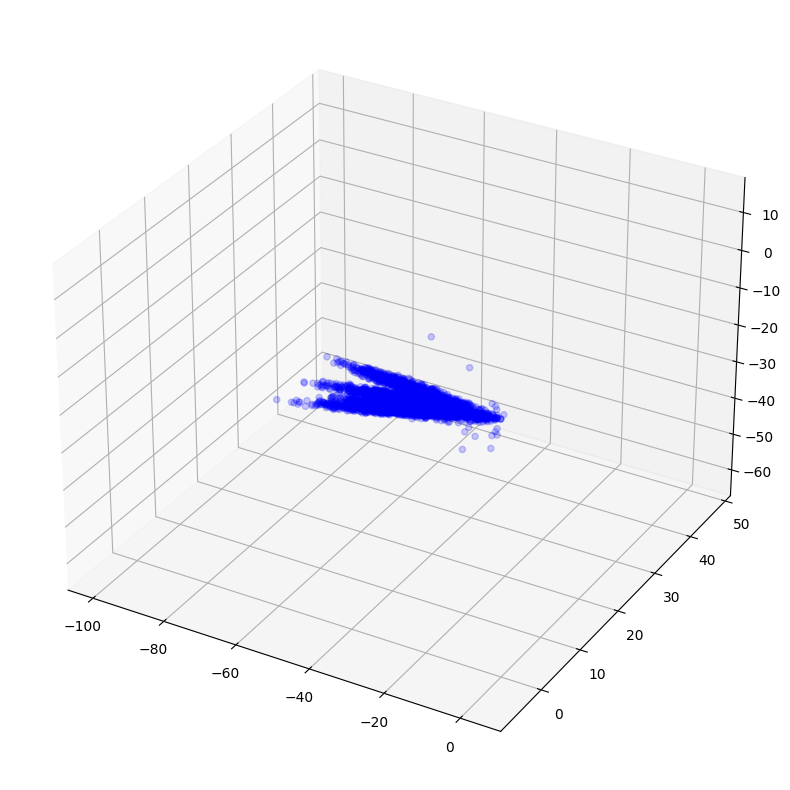

In [6]:
# Create 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='blue', alpha=0.2, label='Data Points')

# Plot each hyperplane as a line
colors = plt.cm.rainbow(np.linspace(0, 1, len(detected_hyperplanes)))
for i, (coef, intercept, num_inliers, hyperplane_error) in enumerate(detected_hyperplanes):
    plot_line_3d(ax, coef, intercept, colors[i], f'Line {i+1}')

# Set labels and title
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('Visualization of Hyperplanes as Lines in 3D')

# Add legend
ax.legend()

# Show the plot
plt.show()



AttributeError: 'Tensor' object has no attribute 'copy'

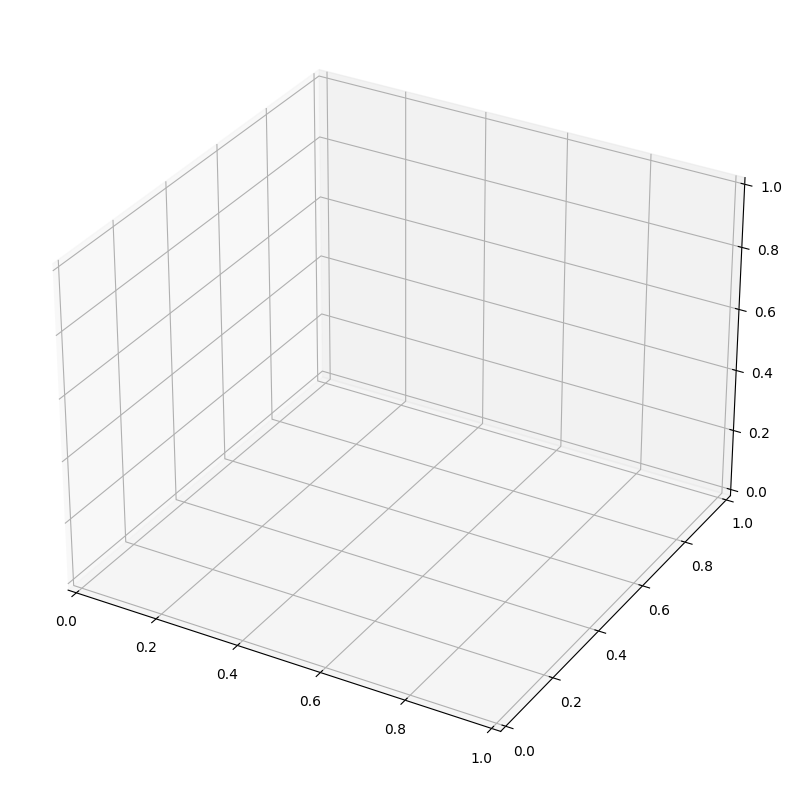

In [7]:
# Set up 3D plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

detected_hyperplanes, total_error, assigned_points = spike_detection_2d_lines(points)

# Plot the data points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='blue', alpha=0.2, label='Data Points')

# Plot each detected hyperplane
for i, (coef, intercept, num_inliers, hyperplane_error) in enumerate(detected_hyperplanes):
    # Create a meshgrid for the hyperplane
    x_range = np.linspace(points[:, 0].min(), points[:, 0].max(), 10)
    y_range = np.linspace(points[:, 1].min(), points[:, 1].max(), 10)
    xx, yy = np.meshgrid(x_range, y_range)
    
    # Calculate corresponding z values for the hyperplane
    if coef[2] != 0:
        zz = (-coef[0] * xx - coef[1] * yy - intercept) / coef[2]
        ax.plot_surface(xx, yy, zz, alpha=0.3, label=f'Hyperplane {i+1}')
    else:
        # Skip plotting if z-coefficient is zero (as it's not a valid plane in 3D)
        continue

# Set plot labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Visualization of Data Points and Detected Hyperplanes')
# ax.legend()

# Show plot
plt.show()


NameError: name 'lines' is not defined

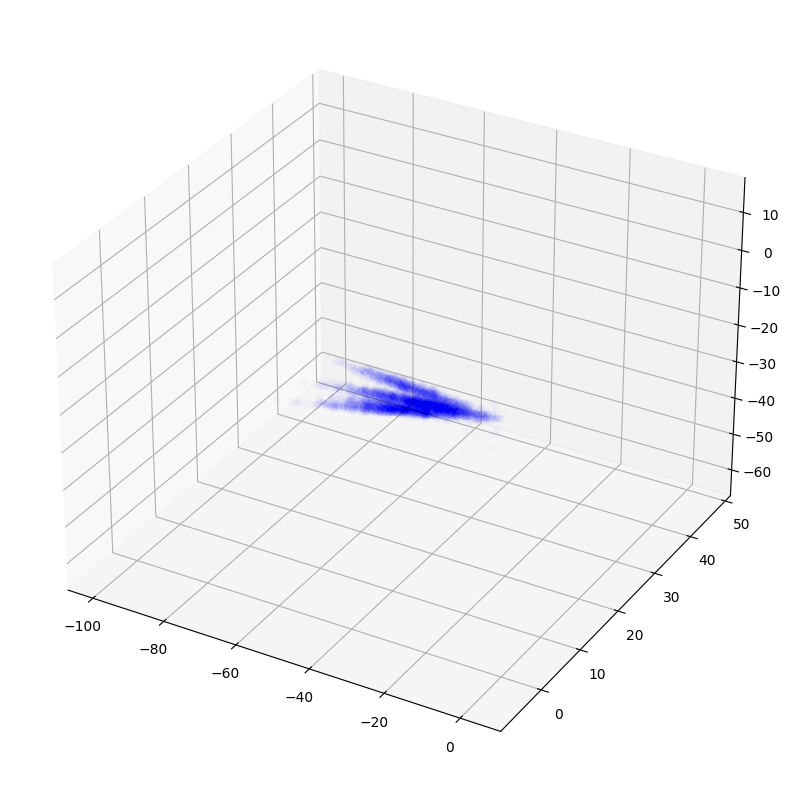

In [8]:
points = class_data.clone().detach().cpu().numpy()


# lines = find_lines_in_nd_space(points)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='blue', alpha=0.01, label='Original Data Points')

for i, (line_direction, line_point, _) in enumerate(lines):
    # Generate points along the detected line
    t_line = np.linspace(-100, 120, 100)
    line_points = line_point + t_line[:, None] * line_direction[None, :]
    ax.plot(line_points[:, 0], line_points[:, 1], line_points[:, 2], label=f'Line {i+1}', color='red', alpha=1)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('Detected Lines in 3D Space')
ax.legend()
plt.show()

In [58]:
import numpy as np
from sklearn.decomposition import PCA

def fit_multiple_lines(points, threshold):
    lines = []
    P = points.copy()

    step = 1
    assigned_points = []

    
    while len(P) > 0:
        # Fit a line using PCA
        pca = PCA(n_components=1)
        pca.fit(P)
        
        line_direction = pca.components_[0]
        line_origin = pca.mean_
        
        # Calculate distances to the line
        distances = np.abs(np.dot(P - line_origin, line_direction))
        
        # Identify points within threshold
        mask = distances < threshold * step
        print(len(mask))
        L = P[mask]
        
        # Remove assigned points from P
        P = P[~mask]
        
        # Store the line
        lines.append((line_direction, line_origin))
        assigned_points.append(L)

    
        step += 1

    return lines, assigned_points

In [ ]:
data = np.array(results_dict['pca_2'][11]).transpose()
# data = torch.Tensor(data)

# Example usage
threshold = 5
fitted_lines, _ = fit_multiple_lines(data, threshold)

print(f"Number of lines fitted: {len(fitted_lines)}")
for i, (direction, origin, _) in enumerate(fitted_lines):
    print(f"Line {i+1}:")
    print(f"  Direction: {direction}")
    print(f"  Origin: {origin}")

50000
48032
45848
43346
40487
37399
34442
31782
29697
28265
27266
26578
26055
25536
25046
24466
23962
23399
22859
22285
21716
21122
20572
20041
19543
19085
18623
18149
17711
17250
16824
16348
15932
15504
15089
14649
14222
13743
13273
12838
12394
11996
11523
11114
10596
10171
9471
8799
8215
7879
7679
7477
6923
6261
5459
4947
4947
4783
4783
4728
4374
4003
3208
2448
1841
1628
1628
1628
1628
1628
1628
1628
1628
1628
1608
1601
1476
1390
1156
815
345
48
Number of lines fitted: 82


ValueError: not enough values to unpack (expected 3, got 2)

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def find_lines_in_nd_space(points, min_points_on_line=50, tolerance=0.2, max_iterations=1000):
    points = np.array(points)
    remaining_points = points.copy()
    lines = []

    def line_function(p0, p1, t):
        """ Function to generate points on the line between p0 and p1 """
        return p0 + t * (p1 - p0)

    iterations = 0
    while len(remaining_points) > min_points_on_line and iterations < max_iterations:
        # Randomly select two different points
        idx1, idx2 = random.sample(range(len(remaining_points)), 2)
        p0 = remaining_points[idx1]
        p1 = remaining_points[idx2]

        # Find points near the line defined by p0 and p1
        points_on_line = []
        for point in remaining_points:
            if np.array_equal(point, p0) or np.array_equal(point, p1):
                points_on_line.append(point)
                continue
            
            # Find the projection of the point onto the line
            v = p1 - p0
            t_optimal = np.dot(point - p0, v) / np.dot(v, v)
            projected_point = line_function(p0, p1, t_optimal)
            
            # Calculate the distance between the point and its projection
            distance = np.linalg.norm(projected_point - point)
            if distance < tolerance:
                points_on_line.append(point)

        points_on_line = np.array(points_on_line)

        # If enough points lie on the line, store the line and remove the points
        if len(points_on_line) >= min_points_on_line:
            line_direction = p1 - p0
            line_direction /= np.linalg.norm(line_direction)  # Normalize the direction
            lines.append((line_direction, p0, points_on_line))

            # Remove points from remaining_points
            mask = np.isin(remaining_points, points_on_line).all(axis=1)
            remaining_points = remaining_points[~mask]

        iterations += 1

    # Merge lines based on angle threshold
    angle_threshold = 0.5  # Threshold in radians to merge lines
    merged_lines = []
    used_lines = set()

    for i, (direction1, point1, points1) in enumerate(lines):
        if i in used_lines:
            continue
        merged_direction = direction1
        merged_points = points1
        for j, (direction2, point2, points2) in enumerate(lines[i+1:], start=i+1):
            if j in used_lines:
                continue
            # Calculate angle between directions
            cos_angle = np.dot(direction1, direction2) / (np.linalg.norm(direction1) * np.linalg.norm(direction2))
            angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
            if angle < angle_threshold:
                # Merge the lines
                merged_direction = (merged_direction + direction2) / 2
                merged_points = np.vstack((merged_points, points2))
                used_lines.add(j)
        merged_lines.append((merged_direction, point1, merged_points))
        used_lines.add(i)

    return merged_lines

# Example usage with 3D data
np.random.seed(42)
num_points = 1000

# Generate some 3D points along a line plus noise
t = np.linspace(-10, 10, num_points)
x = t + np.random.normal(scale=0.5, size=num_points)
y = 2 * t + np.random.normal(scale=0.5, size=num_points)
z = -3 * t + np.random.normal(scale=0.5, size=num_points)
points = np.vstack((x, y, z)).T

# Apply the find_lines_in_nd_space function to find lines in the data
lines = find_lines_in_nd_space(points)

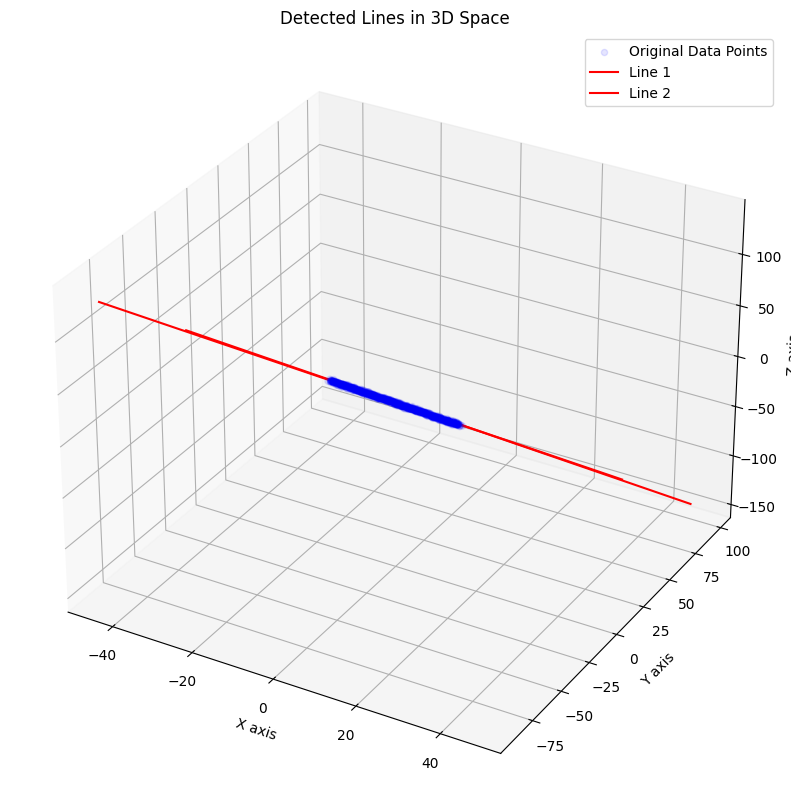

In [10]:
# Plotting the original data points and the detected lines
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='blue', alpha=0.1, label='Original Data Points')

for i, (line_direction, line_point, _) in enumerate(lines):
    # Generate points along the detected line
    t_line = np.linspace(-100, 200, 100)
    line_points = line_point + t_line[:, None] * line_direction[None, :]
    ax.plot(line_points[:, 0], line_points[:, 1], line_points[:, 2], label=f'Line {i+1}', color='red', alpha=1)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('Detected Lines in 3D Space')
ax.legend()
plt.show()